# Finite width effects on the lepton collider in simple collider processes

We are trying to understand the finite-width effects in simple $s$-channel processes like $\mu^+ \mu^- \to Z^\prime \to \ell \bar{\ell}$, where $Z^\prime$ (or any other mediator) has a finite width. \
At lepton colliders, the PDFs are calculable (and are known), so we can use this knowledge to our advantage. The PDFs can be found in https://arxiv.org/pdf/2303.16964 or better here: https://github.com/DavidMarzocca/LePDF.

One of the steps is to compare the analytic forms of the PDFs with the numerical ones, just out of control. We can import the numerical values of the PDFs through LHAPDF and interpolate numerically with scipy.

Note that the LePDF files contain the values of $x \times f(x)$! We however use $f(x)$.

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import matplotlib.colors

from scipy.integrate import quad

from scipy.interpolate import CubicSpline
from scipy.interpolate import PchipInterpolator
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp1d


import lhapdf
import sympy

Plot styling:

In [2]:
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = ['serif']
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18

plt.rcParams['figure.dpi'] = 70

Some nice colors:

In [3]:
niceGreenColors = ['#55a15c', '#87c27e','#add7a1'] 
niceGreenLine = ['#284c2b']

flavioColors = ['#df9695', '#e9b8b8', '#f3dcdc']
flavioLine = ['#c63d35']

niceBlueColors = ['#3182bd','#6baed6','#9ecae1']
niceBlueColorForLine = ['#316e96']

niceOrangeColors = ['#ff5f00', '#ff7726', '#923600']

lo_color = '#009DCF' #for the plot #1
nlo_color = '#004F92'

purpleColors = ['#35377e', '#4e50a7', '#7c7eb7']

#cmsBrown = '#b86551'

cmsBrown = '#73534b'

orangeGinobetaR0 = '#fadfc2' #betaR = 0
purpleGinobetaR1 = '#d9bfdc' #betaR = 1
tab20cblue = plt.cm.tab20c(0)

Set the folder:

In [4]:
os.chdir("/home/armanubuntu/finite-width-lepton-colliders")

The PDF functions written in analytic form:


In [5]:
# Utility functions
def theta(x):
    """Heaviside step function."""
    return np.where(np.array(x) > 0, 1.0, 0.0)

def delta_gaussian(x, sigma=1e-3):
    """Narrow Gaussian approximation to δ(1-x)."""
    x = np.asarray(x)
    norm = 1.0 / (sigma * np.sqrt(2.0 * np.pi))
    return norm * np.exp(-0.5 * ((x - 1.0) / sigma)**2)


# -----------------------------------------------------------------------------
# 1. f_mu^(alpha^2)(x,t)
# -----------------------------------------------------------------------------
def f_mu_alpha2(x, t, alpha_gamma, P_Vff, I_VVf=None, I_ffff=None, delta=delta_gaussian):
    x = np.asarray(x)
    dg = delta(x)
    P = np.asarray(P_Vff(x))
    I_V = np.asarray(I_VVf(x)) if I_VVf is not None else np.zeros_like(x)
    I_f = np.asarray(I_ffff(x)) if I_ffff is not None else np.zeros_like(x)
    pref = alpha_gamma / (2.0 * np.pi)
    term1 = dg
    term2 = pref * t * (1.5 * dg + P)
    term3 = 0.5 * (pref * t)**2 * (2.25 * dg + 3.0 * P + I_V + I_f)
    return term1 + term2 + term3


# -----------------------------------------------------------------------------
# 2. f_lsea^(alpha^2)(x,t)
# -----------------------------------------------------------------------------
def f_lsea_alpha2(x, t, alpha_gamma, I_VVf, delta=delta_gaussian):
    x = np.asarray(x)
    I_V = np.asarray(I_VVf(x))
    pref = alpha_gamma / (2.0 * np.pi)
    return 0.5 * (pref * t)**2 * I_V


# -----------------------------------------------------------------------------
# 3. f_gamma^(alpha^2)(x,t)
# -----------------------------------------------------------------------------
def f_gamma_alpha2(x, t, alpha_gamma, P_Vf, I_Vfff=None, Nf_QED=0):
    x = np.asarray(x)
    P = np.asarray(P_Vf(x))
    Ifff = np.asarray(I_Vfff(x)) if I_Vfff is not None else np.zeros_like(x)
    pref = alpha_gamma / (2.0 * np.pi)
    term1 = pref * t * P
    term2 = 0.5 * (pref * t)**2 * ((1.5 - 2.0/3.0 * Nf_QED) * P + Ifff)
    return term1 + term2


# -----------------------------------------------------------------------------
# 4. f_W±^(alpha)(x,Q^2)
# -----------------------------------------------------------------------------
def f_Wpm_alpha(x, Q2, alpha2, P_Vpm_fL, mW, m_mu):
    x = np.asarray(x)
    P = np.asarray(P_Vpm_fL(x))
    denom = Q2 + (1.0 - x) * mW**2
    denom = np.where(denom == 0, np.finfo(float).tiny, denom)
    logterm = np.log((Q2 + (1.0 - x) * mW**2) / (m_mu**2 + (1.0 - x) * mW**2))
    return (alpha2 / (8.0 * np.pi)) * P * (logterm - Q2 / denom)


# -----------------------------------------------------------------------------
# 5. f_WL^(alpha)(x,Q^2)
# -----------------------------------------------------------------------------
def f_WL_alpha(x, Q2, alpha2, mW):
    x = np.asarray(x)
    safe_x = np.where(x == 0, np.finfo(float).tiny, x)
    denom = Q2 + (1.0 - x) * mW**2
    denom = np.where(denom == 0, np.finfo(float).tiny, denom)
    return (alpha2 / (4.0 * np.pi)) * ((1.0 - x) / safe_x) * (Q2 / denom)


# -----------------------------------------------------------------------------
# 6. f_Z±^(alpha)(x,Q^2)
# -----------------------------------------------------------------------------
def f_Zpm_alpha(x, Q2, alpha2, cW, P_Vpm_fL, P_Vpm_fR, QZ_muL, QZ_muR, mZ, m_mu):
    x = np.asarray(x)
    P_L = np.asarray(P_Vpm_fL(x))
    P_R = np.asarray(P_Vpm_fR(x))
    prefP = P_L * (QZ_muL**2) + P_R * (QZ_muR**2)
    denom = Q2 + (1.0 - x) * mZ**2
    denom = np.where(denom == 0, np.finfo(float).tiny, denom)
    logterm = np.log((Q2 + (1.0 - x) * mZ**2) / (m_mu**2 + (1.0 - x) * mZ**2))
    return (alpha2 / (4.0 * np.pi * cW**2)) * prefP * (logterm - Q2 / denom)


# -----------------------------------------------------------------------------
# 7. f_{Z/gamma ±}^{(alpha)}(x,Q^2)
# -----------------------------------------------------------------------------
def f_Zgamma_pm_alpha(x, Q2, alpha_gamma, alpha2, cW, P_Vpm_fL, P_Vpm_fR, QZ_muL, QZ_muR, mZ, m_mu):
    x = np.asarray(x)
    P_L = np.asarray(P_Vpm_fL(x))
    P_R = np.asarray(P_Vpm_fR(x))
    prefP = P_L * QZ_muL + P_R * QZ_muR
    logterm = np.log((Q2 + (1.0 - x) * mZ**2) / (m_mu**2 + (1.0 - x) * mZ**2))
    return - np.sqrt(alpha_gamma * alpha2) / (2.0 * np.pi * cW) * prefP * logterm


# -----------------------------------------------------------------------------
# 8. f_ZL^(alpha)(x,Q^2)
# -----------------------------------------------------------------------------
def f_ZL_alpha(x, Q2, alpha2, cW, QZ_muL, QZ_muR, mZ):
    x = np.asarray(x)
    safe_x = np.where(x == 0, np.finfo(float).tiny, x)
    denom = Q2 + (1.0 - x) * mZ**2
    denom = np.where(denom == 0, np.finfo(float).tiny, denom)
    prefQ = (QZ_muL**2 + QZ_muR**2)
    return (alpha2 / (2.0 * np.pi * cW**2)) * ((1.0 - x) / safe_x) * prefQ * (Q2 / denom)


# -----------------------------------------------------------------------------
# 9. f_nu_mu^(alpha)(x,Q^2)
# -----------------------------------------------------------------------------
def f_nu_mu_alpha(x, Q2, alpha2, P_Vff, mW):
    x = np.asarray(x)
    P = np.asarray(P_Vff(x))
    threshold = mW**2 / (1.0 - x)**2
    th = theta(Q2 - threshold)
    denom = Q2 + x * mW**2
    denom = np.where(denom == 0, np.finfo(float).tiny, denom)
    term_log1 = np.log((Q2 + x * mW**2) / (mW**2))
    term_log2 = np.log(((1.0 - x)**2) / (1.0 + x * (1.0 - x)**2))
    term_frac = x * mW**2 / denom
    term_last = 1.0 / (1.0 + x * (1.0 - x)**2) - 1.0
    bracket = term_log1 + term_log2 + term_frac + term_last
    return (alpha2 / (8.0 * np.pi)) * th * P * bracket


# -----------------------------------------------------------------------------
# Placeholders for user-supplied functions
# -----------------------------------------------------------------------------
# Replace these later with your model-dependent definitions:
def P_Vff(x): raise NotImplementedError("Define your P_Vff(x)")
def P_Vpm_fL(x): raise NotImplementedError("Define your P_Vpm_fL(x)")
def P_Vpm_fR(x): raise NotImplementedError("Define your P_Vpm_fR(x)")
def I_VVf(x): raise NotImplementedError("Define your I_VVf(x)")
def I_ffff(x): raise NotImplementedError("Define your I_ffff(x)")
def I_Vfff(x): raise NotImplementedError("Define your I_Vfff(x)")



Loading the PDFs from the LHAPDF files:

In [6]:
TeV = 1.0e3
GeV = 1.0
MeV = 1.0e-3
keV = 1.0e-6
eV = 1.0e-9

me = 0.510998950*MeV
mmu = 105.6584*MeV

Set which collider/initial lepton states we are using: 

In [7]:
with open("lePDFs/LePDF_mu_5FS_0000.dat") as f:

    for i in range(9):
        print(f.readline().strip())
    

PdfType: central
Format: lhagrid1
---
1.0000000000e-06 1.1877334415e-06 1.4088893211e-06 1.6690720710e-06 1.9747632557e-06 2.3334480638e-06 2.7537582837e-06 3.2456336402e-06 3.8205035479e-06 4.4914915161e-06 5.2736446449e-06 6.1841908524e-06 7.2428266946e-06 8.4720388665e-06 9.8974627083e-06 1.1548281287e-05 1.3457668878e-05 1.5663282917e-05 1.8207808784e-05 2.1139562004e-05 2.4513152750e-05 2.8390217790e-05 3.2840225243e-05 3.7941357825e-05 4.3781480427e-05 5.0459198155e-05 5.8085011119e-05 6.6782572466e-05 7.6690056272e-05 8.7961642059e-05 1.0076912274e-04 1.1530364285e-04 1.3177757387e-04 1.5042653344e-04 1.7151155498e-04 1.9532141414e-04 2.2217511819e-04 2.5242456399e-04 2.8645736981e-04 3.2469988560e-04 3.6762038586e-04 4.1573244802e-04 4.6959851890e-04 5.2983367044e-04 5.9710954469e-04 6.7215848719e-04 7.5577786596e-04 8.4883457213e-04 9.5226969648e-04 1.0671033743e-03 1.1944397893e-03 1.3354723245e-03 1.4914888473e-03 1.6638771123e-03 1.8541302629e-03 2.0638524128e-03 2.29476428

In [8]:
def load_pdf_grid(path, ml = mmu):
    with open(path) as f:
        lines = f.readlines()

    # Clean and strip lines
    lines = [l.strip() for l in lines if l.strip()]

    # Basic metadata
    pdf_type = lines[0].split(":")[1].strip()
    fmt = lines[1].split(":")[1].strip()

    # Extract grids
    x_grid = np.array(lines[3].split(), dtype=float)
    q_grid = np.array(lines[4].split(), dtype=float)


    print("The xgrid is", len(x_grid))
    print("The q_grid is", len(q_grid))

    # Labels and metadata
    labels = lines[5].split()
    pdg_ids = lines[6].split()
    polarizations = lines[7].split()

    nx = len(x_grid)
    nq = len(q_grid)
    n_flavs = len(labels)

    print("nx is {0}, nq is {1}, and n_flavs is {2}".format(nx, nq, n_flavs))

    # The remaining lines are PDF values
    # Fill array: shape = (nq, nx, n_flavs)
    # NOTE: Mathematica fills columns first (fixed x, vary Q),
    # while np.loadtxt reads rows. So we transpose the indexing logic.

    data_lines = lines[8:]
    data = np.zeros((nq, nx, n_flavs), dtype=float)

    # In the LePDF files, each block corresponds to fixed x, varying Q.
    # So we must read column-wise rather than row-wise.
    # Convert to numeric array
    flat_data = np.array([line.split() for line in data_lines], dtype=float)    # Load as a big array: shape = (nq, nx, n_flavs)

    # We fix that by reshaping accordingly:
    for i in range(n_flavs):
        col = flat_data[:, i]
        # Now reshape this flat column into (nx, nq) and transpose to (nq, nx)
        col_reshaped = col.reshape(nx, nq).T
        data[:, :, i] = col_reshaped



    # Build the 2D interpolation functions
    pdfs = {}
    t_grid = np.log(q_grid**2 / ml**2)  # log(Q^2 / ml^2)
    
    for i, label in enumerate(labels):
        # Step 1: for each x, interpolate along t (Q dimension)
        interp_t_at_x = []
        for ix in range(nx):
            f_t = CubicSpline(t_grid, data[:, ix, i], bc_type='natural', extrapolate=False)
            interp_t_at_x.append(f_t)
        
        # Step 2: define full PDF[Q](x) = x-interpolation of values f_t(Q)
        def make_pdf_func(ix_interps):
            def pdf_func(x, Q):
                # get values at each x_i for given Q
                t = np.log(Q**2 / ml**2)
                vals = np.array([f_t(t) for f_t in ix_interps])
                fx = CubicSpline(x_grid, vals, bc_type='natural', extrapolate=False)
                return fx(x) / x  # divide by x as in David's code
            return pdf_func 
        
        pdfs[label] = make_pdf_func(interp_t_at_x)
    
    
    return {
        "x": x_grid,
        "Q": q_grid,
        "labels": labels,
        "pdg_ids": pdg_ids,
        "polarizations": polarizations,
        "pdfs": pdfs,
        "pdf_type": pdf_type,
        "format": fmt
    }


This function can be used like this:

In [9]:
grid = load_pdf_grid("lePDFs/LePDF_mu_5FS_0000.dat", ml=mmu) # Make sure to set the lepton mass appropriately to the PDF set

# Example: get uL PDF from a muon, at x=0.01, Q=100 GeV
lepPDF = grid["pdfs"]["eL"](0.01, 100.0)
print(lepPDF)

The xgrid is 281
The q_grid is 45
nx is 281, nq is 45, and n_flavs is 55
0.00826402397872833


In [10]:
x_grid = grid["x"]
q_grid = grid["Q"]

grid["pdfs"]["eL"](x_grid[0], q_grid[3])


47.9795

Plot one of these functions:

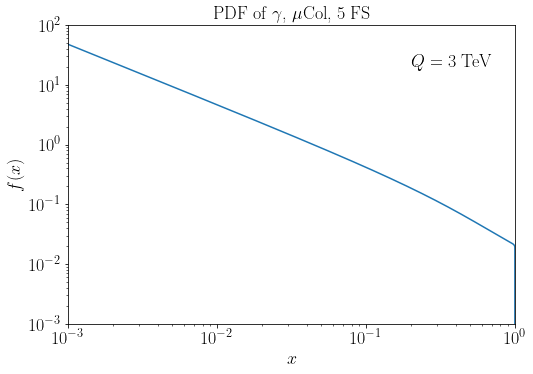

In [11]:
y = (grid["pdfs"]["gam"](x_grid, 3000) + grid["pdfs"]["gap"](x_grid, 3000))

fig, ax = plt.subplots(1,1, figsize=(8, 5.5))

ax.plot(x_grid, y)
ax.set_title(r"PDF of $\gamma$, $\mu$Col, 5 FS", fontsize = 18)
ax.set_xlabel(r"$x$", fontsize = 18)
ax.set_ylabel(r"$f(x)$", fontsize = 18)


ax.set_yscale("log")
ax.set_ylim(1e-3, 100)
ax.set_xscale("log") 
ax.set_xlim(1e-3, 1)

ax.text(x = 0.2, y = 20, s = r'$Q = 3$ TeV', fontsize = 18)


plt.show()



For the CP conjugated:

In [12]:
ParticleList6FS = ["eL","eR","nue","muL","muR","numu","taL","taR","nuta","eLb","eRb","nueb", "muLb", "muRb", "numub", "taLb", "taRb", "nutab", "dL", "dR", "uL", "uR", "sL", "sR", "cL", "cR", "bL", "bR", "tL","tR",
                   "dLb", "dRb", "uLb", "uRb", "sLb", "sRb", "cLb", "cRb", "bLb", "bRb", "tLb", "tRb", 
                   "gp", "gm", "gap", "gam", "Zp", "Zm","ZL", "Zgap", "Zgam", "Wpp", "Wpm", "WpL", "Wmp", "Wmm", "WmL", "h", "hZL"]

ParticleList6FSCP = ["eLb","eRb", "nueb", "muLb", "muRb", "numub", "taLb", "taRb","nutab", "eL", "eR", "nue", "muL", "muR", "numu","taL","taR","nuta", "dLb", "dRb", "uLb", "uRb", "sLb", "sRb", "cLb", "cRb", "bLb", "bRb", "tLb", "tRb",
                     "dL", "dR", "uL", "uR", "sL", "sR", "cL", "cR", "bL", "bR", "tL", "tR", 
                     "gm", "gp", "gam", "gap", "Zm", "Zp", "ZL", "Zgam", "Zgap", "Wmm", "Wmp", "WmL", "Wpm", "Wpp", "WpL", "h", "hZL"]

def CPconjugate(particle):
    if particle in ParticleList6FS:
        index = ParticleList6FS.index(particle)
        return ParticleList6FSCP[index]
    else:
        raise ValueError(f"Particle '{particle}' not found in either list.")

# The CP conjugated example: get uL PDF from an anti-muon, at x=0.01, Q=100 GeV    
lepbarPDF = grid["pdfs"][CPconjugate("uL")](0.01, 100.0)
print(lepbarPDF)


0.011623349639577474


Plot one of these functions:

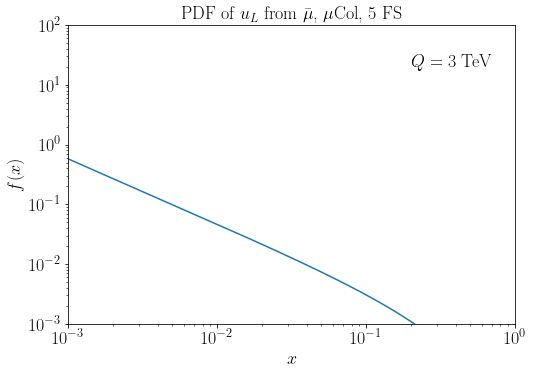

In [13]:
x_grid = grid["x"]
y = grid["pdfs"][CPconjugate("uL")](x_grid, 3000)

fig, ax = plt.subplots(1,1, figsize=(8, 5.5))

ax.plot(x_grid, y)
ax.set_title(r"PDF of $u_L$ from $\bar{\mu}$, $\mu$Col, 5 FS", fontsize = 18)
ax.set_xlabel(r"$x$", fontsize = 18)
ax.set_ylabel(r"$f(x)$", fontsize = 18)


ax.set_yscale("log")
ax.set_ylim(1e-3, 100)
ax.set_xscale("log") 
ax.set_xlim(1e-3, 1)

ax.text(x = 0.2, y = 20, s = r'$Q = 3$ TeV', fontsize = 18)


plt.show()



Now that we have the PDFs, let us define the luminosity functions

## Numerical parton luminosity functions (PLFs)

The PLFs are defined as: 
\begin{equation}
\mathcal{L}_{ij} (\tau) = \int_{\tau}^{1} \frac{dx}{x} f_i^{\mu} \left( x, Q \right) f_j^{\bar{\mu}} (\tau / x, Q)
\end{equation}

where we can set $Q$ for example dynamically to $Q = \sqrt{\tau S_{\rm had}}/2$.

In [14]:
def parton_lumi(i, j, tau, Q):
    """Compute parton luminosity for partons i, j at given tau and scale Q."""
    def integrand(x):
        xi = x
        xj = tau / x
        if xj > 1.0:
            return 0.0
        fi = grid["pdfs"][i](xi, Q)
        fj = grid["pdfs"][j](xj, Q)
        return fi * fj / x

    result, error = quad(integrand, tau, 1.0)
    return result

In [15]:
# Example: compute luminosity for uL from mu- and uL from mu+ at tau=0.1, Q=1 TeV
tau = 0.1
qVal = 1000.0
lumi_uL_uLbar_val = parton_lumi("uL", CPconjugate("uL"), tau, qVal)
print(f"Luminosity for uL from mu- and uL from mu+ at tau={tau}, Q={qVal} GeV: {lumi_uL_uLbar_val}")

Luminosity for uL from mu- and uL from mu+ at tau=0.1, Q=1000.0 GeV: 1.2417808884078734e-07


Let us now define a range of $\tau$ and then calculate the PLF for a dynamically varying $Q$ and plot it:

In [16]:
taus = np.logspace(-4, 0, 100)

Define the COM energy that we use:

In [17]:
Shad = (3.0*TeV)**2  # don't forget, the PDFs are taking values in GeV, i.e. GeV^2 here

In [18]:
lumi_vals_uLuLbar = [parton_lumi("uL", CPconjugate("uL"), tau, np.sqrt(tau*Shad)/2) for tau in taus]

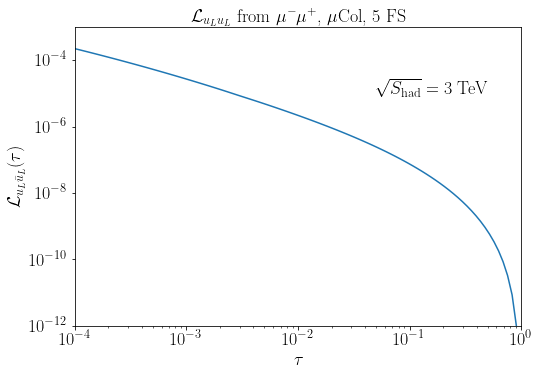

In [19]:
fig, ax = plt.subplots(1,1, figsize=(8, 5.5))
ax.plot(taus, lumi_vals_uLuLbar)
ax.set_title(r"$\mathcal{L}_{u_L u_L}$ from $\mu^- \mu^+$, $\mu$Col, 5 FS", fontsize = 18)
ax.set_xlabel(r"$\tau$", fontsize = 18)
ax.set_ylabel(r"$\mathcal{L}_{u_L \bar{u}_L}(\tau)$", fontsize = 18)

ax.text(x = 0.05, y = 1e-5, s = r'$\sqrt{S_{\rm had}} = 3$ TeV', fontsize = 18)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-4, 1)
ax.set_ylim(1e-12, 1e-3)  

plt.show()

There is a little problem with $\mu$-PDFs, since they diverge close to $x \sim 1$. 
As another example, take the PDFs from electrons.

In [20]:
lumi_vals_eLeLbar = [parton_lumi("eL", CPconjugate("eL"), tau, np.sqrt(tau*Shad)/2) for tau in taus]

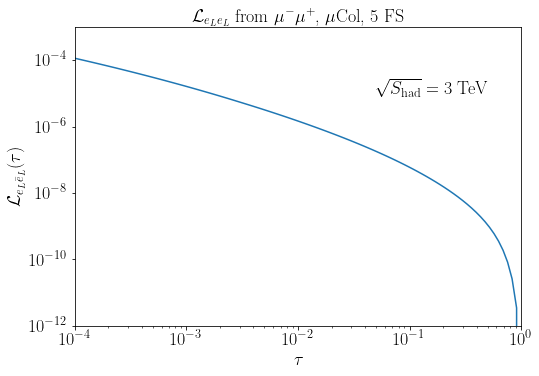

In [21]:
fig, ax = plt.subplots(1,1, figsize=(8, 5.5))
ax.plot(taus, lumi_vals_eLeLbar)
ax.set_title(r"$\mathcal{L}_{e_L e_L}$ from $\mu^- \mu^+$, $\mu$Col, 5 FS", fontsize = 18)
ax.set_xlabel(r"$\tau$", fontsize = 18)
ax.set_ylabel(r"$\mathcal{L}_{e_L \bar{e}_L}(\tau)$", fontsize = 18)

ax.text(x = 0.05, y = 1e-5, s = r'$\sqrt{S_{\rm had}} = 3$ TeV', fontsize = 18)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-4, 1)
ax.set_ylim(1e-12, 1e-3)  

plt.show()

Let's also do photons, so we have something to compare with David's paper:

In [22]:
lumi_vals_gammagamma = [(parton_lumi("gap", CPconjugate("gap"), tau, np.sqrt(tau*Shad)/2) + parton_lumi("gam", CPconjugate("gam"), tau, np.sqrt(tau*Shad)/2)) for tau in taus]

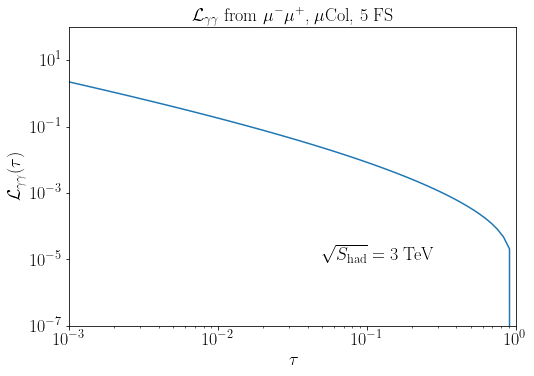

In [23]:
fig, ax = plt.subplots(1,1, figsize=(8, 5.5))
ax.plot(taus, lumi_vals_gammagamma)
ax.set_title(r"$\mathcal{L}_{\gamma \gamma}$ from $\mu^- \mu^+$, $\mu$Col, 5 FS", fontsize = 18)
ax.set_xlabel(r"$\tau$", fontsize = 18)
ax.set_ylabel(r"$\mathcal{L}_{\gamma \gamma}(\tau)$", fontsize = 18)

ax.text(x = 0.05, y = 1e-5, s = r'$\sqrt{S_{\rm had}} = 3$ TeV', fontsize = 18)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-3, 1)
ax.set_ylim(1e-7, 100)  

plt.show()

Alright! We have the PLFs. We need now information about the cross-section $\sigma$.

For now, we should focus getting a numerical result. So, let's say we have a $Z^\prime$ that couples to whatever, gives me whatever..it can be something very simple for now, like $e_L^- e_L^+ \to Z^\prime \to e_L^- e_L^+$ or whatever. The details are not important. Take a look at David's and Admir's paper. The only difference is I think the color factors and we are $\textit{neglecting for now}$ the SM. We want to compare the narrow-width result to the Breit-Wigner numerical integration. \\

So in principle we will deal with 3 results:
1) NWA numerical (and analytical, since it's easy to derive it)
2) BW numerical
3) BW theoretical (hopefully)

## The convolution with the partonic cross-section; getting $\sigma_{\rm NWA}$ and $\sigma_{\rm BW}$

We can for now ignore any details, it's just important that we agree on the partonic x-sec, and use the same for NWA and the BW case. See the Overleaf.

In [24]:
def xsecPartonicBW(tau, MZp, g4):
    """Example partonic cross-section for mu_L mu_L -> Z' -> mu_L mu_L, simple s-channel, Breit-Wigner."""
    
    num = tau*Shad*g4**4 # simple s-channel

    GammaZp = (g4**2) * MZp / (12.0 * np.pi)  # The width formula - assume only this decay channel!
    breit_wigner = 1/((tau*Shad - MZp**2)**2 + MZp**2 * GammaZp**2)

    return num * breit_wigner / (144.0 * np.pi)  # the 144 pi is just a made-up factor for now. Should be 36 I think, we don't have color


def xsecHadronicIntegrandBW(tau, MZp, g4):
    qVal = np.sqrt(tau * Shad) / 2.0
    lumi = parton_lumi("eL", CPconjugate("eL"), tau, qVal)
    sigma_hat = xsecPartonicBW(tau, MZp, g4)
    return lumi * sigma_hat


def xsecHadronicBW(MZp, g4):
    
    """Hadronic cross-section via convolution with parton luminosities."""

    def integrand(tau):
        func = xsecHadronicIntegrandBW(tau, MZp, g4)
        return func

    result, error = quad(integrand, (4*ml**2)/Shad, 1)
    return result


# For the NWA, the tau integration is trivial, since the delta function fixes tau = MZp^2/Shad
# So we just need to evaluate the luminosity at that point and multiply by the partonic cross-section at that point

def xsecPartonicNWA(MZp, g4):
    """Example partonic cross-section for mu_L mu_L -> Z' -> mu_L mu_L, simple s-channel, in the NWA."""
    #Don't forget the pi/m gamma factor from the delta function integration!
    
    num = ((MZp**2)/Shad)*g4**4 
    # ehhh but the tau is set to ...m^2 / Shad no???

    GammaZp = (g4**2) * MZp / (12.0 * np.pi)  # The width formula - assume only this decay channel!

    convNWA = np.pi/(MZp*GammaZp)


    return num * convNWA / (144.0 * np.pi)  # the 144 pi is just a made-up factor for now. Should be 36 I think, we don't have color




def xsecHadronicNWA(MZp, g4):
    qVal = MZp/2.0 # the dynamic scale choice transformed to a static due to the delta-function. 
    lumi = parton_lumi("eL", CPconjugate("eL"), MZp**2/Shad, qVal)
    sigma_hat = xsecPartonicNWA(MZp, g4)
    return lumi * sigma_hat



def xsecBWvsNWARatio(MZp, g4):
    """Ratio of full finite-width cross-section to NWA cross-section. We simplify the relation to cure numerical issues with g4 -> 0"""
    
    GammaZp = (g4**2) * MZp / (12.0 * np.pi)

    def integrand(tau):
        qVal = np.sqrt(tau * Shad) / 2.0
        func = tau * parton_lumi("eL", CPconjugate("eL"), tau, qVal) / (((tau*Shad - MZp**2)**2 + MZp**2 * GammaZp**2))
        return func
    
    result, error = quad(integrand, (4*ml**2/Shad), 1)

    return (Shad**2) * (GammaZp/(MZp*np.pi)) * result / parton_lumi("eL", CPconjugate("eL"), MZp**2/Shad, MZp/2.0)
   
    # Shad comes from sigma_BW, the other from sigma_NWA (M^2 / Shad = tau), Gamma/ (M pi) from the delta-function, and we have to divide by the luminosity at the resonance point. 

In [25]:
MZpExample = 1000.0  # in GeV
g4Example1 = 5.0
g4Example2 = 1.0

xsecHadronic_vals_eLeLbar_BW1 = [xsecHadronicIntegrandBW(tau, MZpExample, g4Example1) for tau in taus]
xsecHadronic_vals_eLeLbar_BW2 = [xsecHadronicIntegrandBW(tau, MZpExample, g4Example2) for tau in taus]


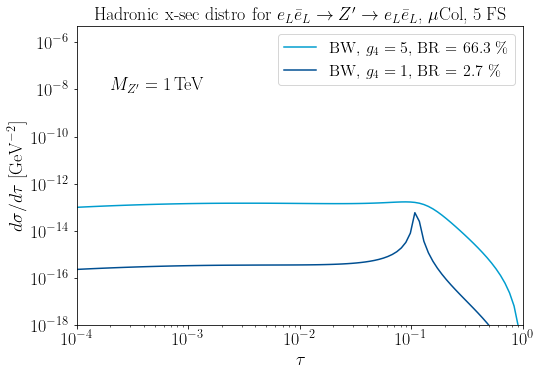

In [26]:
fig, ax = plt.subplots(1,1, figsize=(8, 5.5))
ax.plot(taus, xsecHadronic_vals_eLeLbar_BW1, label = rf"BW, $g_{4} = {g4Example1:.0f}$, BR = {1e2*g4Example1**2/(12.0*np.pi):.1f} \%", color = lo_color)
ax.plot(taus, xsecHadronic_vals_eLeLbar_BW2, label =  rf"BW, $g_{4} = {g4Example2:.0f}$, BR = {1e2*g4Example2**2/(12.0*np.pi):.1f} \%", color = nlo_color)

ax.legend(fontsize = 16)
ax.set_title(r"Hadronic x-sec distro for $e_L \bar{e}_L \to Z' \to e_L \bar{e}_L$, $\mu$Col, 5 FS", fontsize = 18)
ax.set_xlabel(r"$\tau$", fontsize = 18)
ax.set_ylabel(r"$d\sigma/d\tau$ [$\mathrm{GeV}^{-2}$]", fontsize = 18)   
ax.text(x = 2e-4, y = 1e-8, s = rf"$M_{{Z^\prime}} = {MZpExample*1e-3:.0f}\,\mathrm{{TeV}}$", fontsize = 18)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-4, 1)
ax.set_ylim(1e-18, 5e-6) 
plt.show()

Total hadronic cross-section (the integral of the curve above:)

In [29]:
ml = mmu

In [30]:
xsecHadronic_val_BW1 = xsecHadronicBW(MZpExample, g4Example1)
xsecHadronic_val_NWA1 = xsecHadronicNWA(MZpExample, g4Example1)

xsecHadronic_val_BW2 = xsecHadronicBW(MZpExample, g4Example2)
xsecHadronic_val_NWA2 = xsecHadronicNWA(MZpExample, g4Example2)

xsecHadronic_val_BW3 = xsecHadronicBW(MZpExample, 0.25)
xsecHadronic_val_NWA3 = xsecHadronicNWA(MZpExample, 0.25)



print("BW vs NWA, g4 = 5: ", xsecHadronic_val_BW1, xsecHadronic_val_NWA1, xsecHadronic_val_BW1/xsecHadronic_val_NWA1)
print("BW vs NWA, g4 = 1: ", xsecHadronic_val_BW2, xsecHadronic_val_NWA2, xsecHadronic_val_BW2/xsecHadronic_val_NWA2)
print("BW vs NWA, g4 = 0.25: ", xsecHadronic_val_BW3, xsecHadronic_val_NWA3, xsecHadronic_val_BW3/xsecHadronic_val_NWA3)

BW vs NWA, g4 = 5:  2.7297364700125586e-14 3.6052587854114845e-14 0.7571540997440497
BW vs NWA, g4 = 1:  3.679241038235482e-15 1.4421035141645938e-15 2.5513016243961206
BW vs NWA, g4 = 0.25:  5.0974953700997256e-17 9.013146963528711e-17 0.565562216030262


The final $\sigma_{\rm BW}/ \sigma_{\rm NWA}$ vs. $g_4$ (and $\Gamma$) plot:

In [31]:
MZpVal = [500.0, 1000.0, 1500.0] # in GeV
g4val = np.linspace(0.01, 5.0, 50)
xsecHadronic_over_g4 = [[xsecBWvsNWARatio(MZp, g4) for g4 in g4val] for MZp in MZpVal]

np.save('xsecHadronic_MZpVal_g4val.npy', xsecHadronic_over_g4)

No need to run the code above, just read the array:

In [32]:
xsecHadronic_over_g4 = np.load('xsecHadronic_MZpVal_g4val.npy')

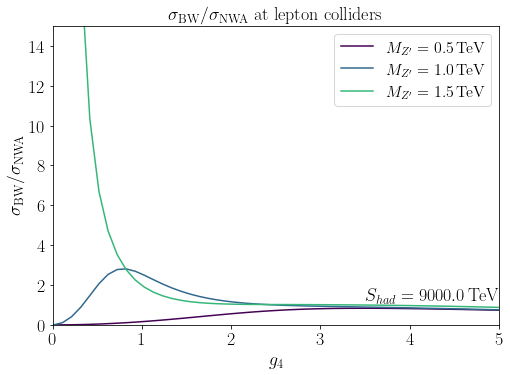

In [33]:
fig, ax = plt.subplots(1,1, figsize=(8, 5.5))
for i in range(len(MZpVal)):
    ax.plot(g4val, xsecHadronic_over_g4[i], label = rf"$M_{{Z^\prime}} = {MZpVal[i]*1e-3:.1f}\,\mathrm{{TeV}}$", color = plt.cm.viridis(i/len(MZpVal)))
ax.set_title(r"$\sigma_{\rm BW}/\sigma_{\rm NWA}$ at lepton colliders", fontsize = 18)
ax.set_xlabel(r"$g_4$", fontsize = 18)
ax.set_ylabel(r"$\sigma_{\rm BW}/\sigma_{\rm NWA}$", fontsize = 18)   
ax.text(x = 3.5, y = 1.2, s = rf"$S_{{had}} = {Shad*1e-3:.1f}\,\mathrm{{TeV}}$", fontsize = 18)
ax.set_xlim(0, 5)
ax.set_ylim(0, 15)
ax.legend(fontsize = 16)

plt.show()

I think the problem is that if Shad is not much bigger than M^2, the BW-NWA analogy works. In the case of 1 TeV, everything is fine. What is this peak though? \
EDIT: Can be simply understood by ofc taking a derivative.

In [38]:
MZpVal = [500.0, 1000.0, 1500.0] # in GeV
g4val = np.logspace(-4, 1, 50) #the -4 and 1 are exponents here
xsecHadronic_over_g4 = [[xsecBWvsNWARatio(MZp, g4) for g4 in g4val] for MZp in MZpVal]

np.save('xsecHadronic_MZpVal_g4val_log.npy', xsecHadronic_over_g4)

In [39]:
g4val

array([1.00000000e-04, 1.26485522e-04, 1.59985872e-04, 2.02358965e-04,
       2.55954792e-04, 3.23745754e-04, 4.09491506e-04, 5.17947468e-04,
       6.55128557e-04, 8.28642773e-04, 1.04811313e-03, 1.32571137e-03,
       1.67683294e-03, 2.12095089e-03, 2.68269580e-03, 3.39322177e-03,
       4.29193426e-03, 5.42867544e-03, 6.86648845e-03, 8.68511374e-03,
       1.09854114e-02, 1.38949549e-02, 1.75751062e-02, 2.22299648e-02,
       2.81176870e-02, 3.55648031e-02, 4.49843267e-02, 5.68986603e-02,
       7.19685673e-02, 9.10298178e-02, 1.15139540e-01, 1.45634848e-01,
       1.84206997e-01, 2.32995181e-01, 2.94705170e-01, 3.72759372e-01,
       4.71486636e-01, 5.96362332e-01, 7.54312006e-01, 9.54095476e-01,
       1.20679264e+00, 1.52641797e+00, 1.93069773e+00, 2.44205309e+00,
       3.08884360e+00, 3.90693994e+00, 4.94171336e+00, 6.25055193e+00,
       7.90604321e+00, 1.00000000e+01])

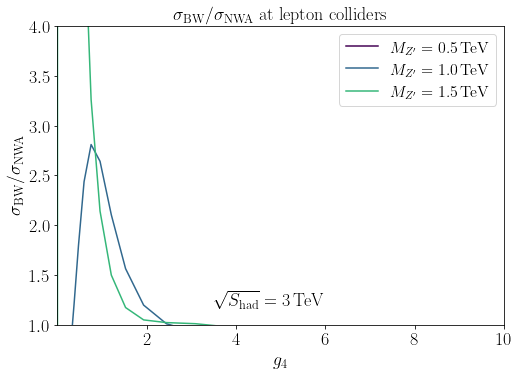

In [59]:
fig, ax = plt.subplots(1,1, figsize=(8, 5.5))
for i in range(len(MZpVal)):
    ax.plot(g4val, xsecHadronic_over_g4[i], label = rf"$M_{{Z^\prime}} = {MZpVal[i]*1e-3:.1f}\,\mathrm{{TeV}}$", color = plt.cm.viridis(i/len(MZpVal)))
ax.set_title(r"$\sigma_{\rm BW}/\sigma_{\rm NWA}$ at lepton colliders", fontsize = 18)
ax.set_xlabel(r"$g_4$", fontsize = 18)
ax.set_ylabel(r"$\sigma_{\rm BW}/\sigma_{\rm NWA}$", fontsize = 18)   
ax.text(x = 3.5, y = 1.2, s = rf"$ \sqrt{{S_{{\rm had}}}} = {np.sqrt(Shad)/1000:.0f}\,\mathrm{{TeV}}$", fontsize = 18)
#ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlim(5e-4, 10)
ax.set_ylim(1, 4)
ax.legend(fontsize = 16)

plt.show()